# Import Libraries

In [3]:
# General Imports
import os
import numpy as np  # For numerical operations
import pandas as pd  # For data processing
import cv2  # For image processing
import matplotlib.pyplot as plt  # For plotting
import itertools
import imutils  # For image rotation and translation
import seaborn as sns  # For advanced plotting
from tqdm import tqdm  # For progress bar
from PIL import Image  # Image manipulation
from sklearn.utils import shuffle  # Data shuffling
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation

# TensorFlow/Keras Imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation
from tensorflow.keras.models import load_model  # Loading pre-trained models
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout  # Layers
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)  # Pre-trained models
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
)  # Training callbacks
from tensorflow.keras.utils import to_categorical  # Utility for one-hot encoding

# IPython Widgets and Display
import ipywidgets as widgets  # Interactive widgets
from IPython.display import display, clear_output  # For display in Jupyter Notebook

# Filter Warnings
from warnings import filterwarnings
filterwarnings('ignore')  # Suppress warnings for cleaner output

ModuleNotFoundError: No module named 'tensorflow.keras'

# **Data Preperation**

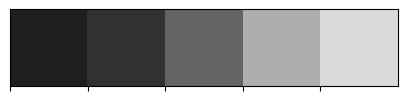

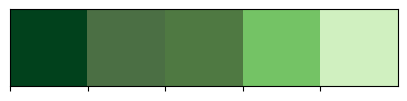

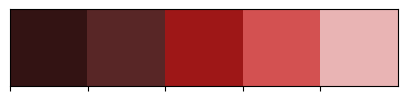

In [2]:
# Ensure consistent colors for plots
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C', '#4B6F44', '#4F7942', '#74C365', '#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image


# **Experiments on CE-MRI Figshare Brain Tumor Dataset**

## **Steps**
1. Crop brain contunour
2. Split the dataset into train and test folder in 80:20 ratio
3. Generate augmented images for each class in train folder only
4. class folder name in both folder i.e. train and test should be glioma, meningioma, pituitary tumor labeled as 1, 2 and 3

In [5]:
# Paths to original and augmented data directories
base_dir = r'C:/_D/Uni/Minor Project/brain-tumor-classification/dataset'
cropped_test_dir = os.path.join(base_dir, 'cropped/test')
augmented_train_dir = os.path.join(base_dir, 'augmented/train')

In [6]:
# Updated code for the new folder structure
X_train = []
y_train = []
X_test = []
y_test = []

# Mapping for class labels
class_counts = {
    '1': 'Glioma', 
    '2': 'Meningioma', 
    '3': 'Pituitary Tumor'
}

image_size = 240

print("Train Set")
print("===========")
for class_id, class_name in class_counts.items():
    # Path to the train folder
    folderPath = os.path.join(augmented_train_dir, class_id)
    for img_name in tqdm(os.listdir(folderPath), desc=f"Processing {class_name} images"):
        img = cv2.imread(os.path.join(folderPath, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(class_name)  # Use the class name as the label

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Test Set")
print("=========")
for class_id, class_name in class_counts.items():
    # Path to the test folder
    folderPath = os.path.join(cropped_test_dir, class_id)
    for img_name in tqdm(os.listdir(folderPath), desc=f"Processing {class_name} images"):
        img = cv2.imread(os.path.join(folderPath, img_name))
        img = cv2.resize(img, (image_size, image_size))
        X_test.append(img)
        y_test.append(class_name)  # Use the class name as the label

X_test = np.array(X_test)
y_test = np.array(y_test)


Train Set


Processing Pituitary Tumor images: 100%|██████████| 4352/4352 [00:32<00:00, 135.05it/s]


Test Set


Processing Pituitary Tumor images: 100%|██████████| 93/93 [00:00<00:00, 100.58it/s]


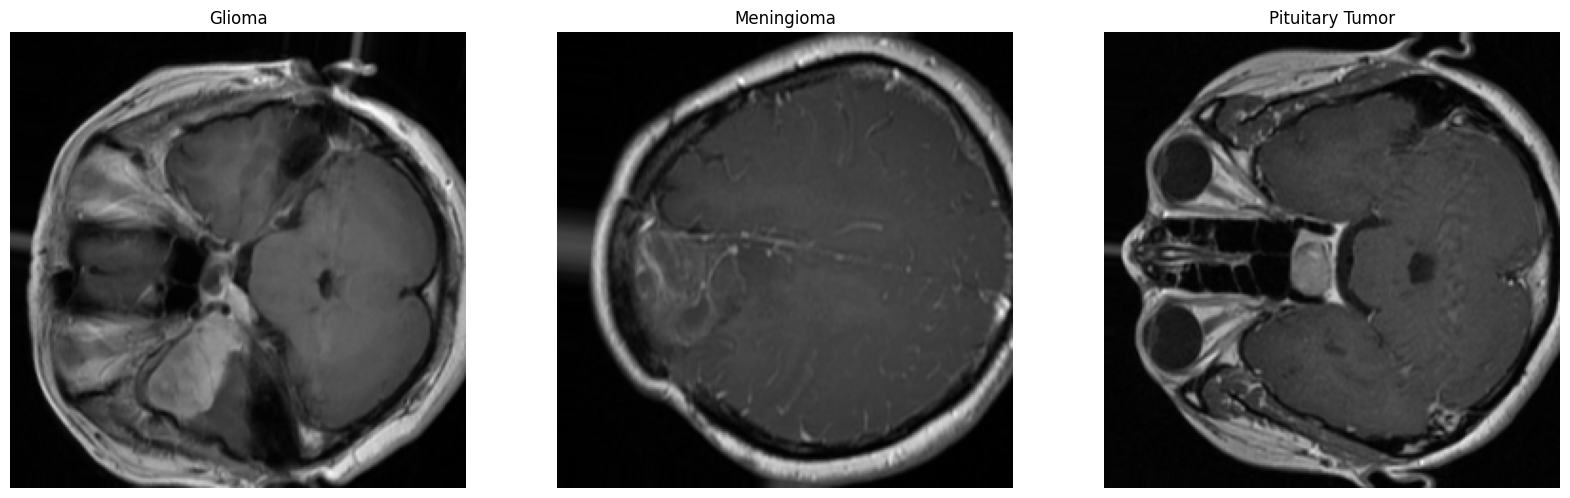

In [7]:
# Plot samples from the train set
k = 0
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

# Use the class names from class_counts for plotting
for class_name in class_counts.values():
    j = 0
    while True:
        if y_train[j] == class_name:  # Check against class name
            ax[k].imshow(cv2.cvtColor(X_train[j], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
            ax[k].set_title(class_name)  # Set title as the class name
            ax[k].axis('off')
            k += 1
            break
        j += 1

plt.show()

In [8]:
# dataset shuffling
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_test, y_test = shuffle(X_test,y_test, random_state=101)

In [9]:
print("x train=",X_train.shape)
print("y train=",y_train.shape)

print("x test=",X_test.shape)
print("y test=",y_test.shape)


x train= (13059, 240, 240, 3)
y train= (13059,)
x test= (309, 240, 240, 3)
y test= (309,)


<Axes: xlabel='count'>

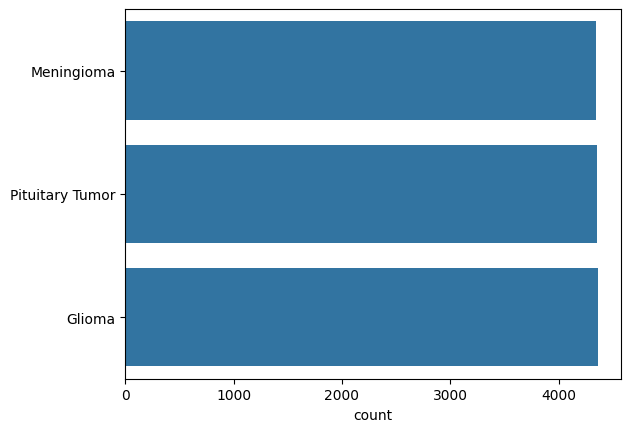

In [10]:
sns.countplot(y_train)

<Axes: xlabel='count'>

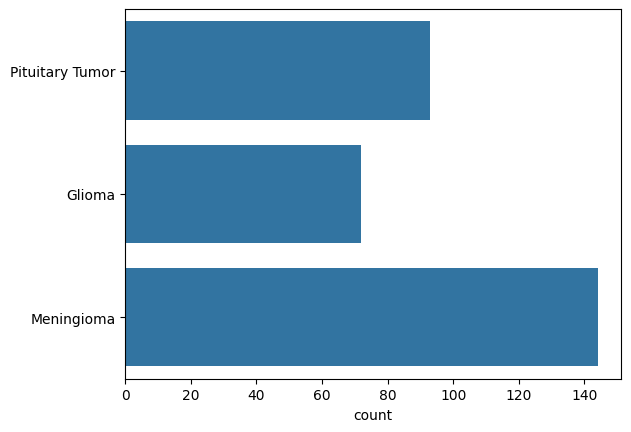

In [11]:
sns.countplot(y_test)

In [12]:
# Label encoding for y_train
y_train_new = []
for i in y_train:
    for key, value in class_counts.items():
        if i == value:  # Match class name to value in class_counts
            y_train_new.append(int(key) - 1)  # Convert to 0-based index
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

# Label encoding for y_test
y_test_new = []
for i in y_test:
    for key, value in class_counts.items():
        if i == value:  # Match class name to value in class_counts
            y_test_new.append(int(key) - 1)  # Convert to 0-based index
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


## **EfficientNet B1**

### **Load Weights**

In [13]:
effnet = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

AttributeError: module 'keras' has no attribute 'KerasTensor'

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
# Define TensorBoard callback
tensorboard = TensorBoard(log_dir=r'C:/_D/Uni/Minor Project/brain-tumor-classification/logs')

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    r'C:/_D/Uni/Minor Project/brain-tumor-classification/saved-models/effnetb1v2.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="auto",
    verbose=1
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.3, 
    patience=5, 
    min_delta=0.001,
    mode='auto',
    verbose=1
)


### **Training The Model**

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### **Prediction**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

### **Evaluation**

In [ ]:
loss,acc = model.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

In [ ]:
# Ensure `pred` is in the same format as `y_test_new` (integer labels)
# Convert predictions from one-hot encoded to integer labels if necessary
if pred.ndim > 1:
    pred = np.argmax(pred, axis=1)

# Print classification report
print(classification_report(y_test_new, pred, target_names=list(class_counts.values()), digits=4))


In [ ]:
# Plot confusion matrix
confusion_mtx = confusion_matrix(y_test_new,pred)
cm = plot_confusion_matrix(confusion_mtx, target_names=list(class_counts.values()), normalize=False)

In [ ]:
ind_list = np.argwhere((y_test_new == pred) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test_new[i]}\nPredicted class: {pred[i]}')
        plt.show()